I am using the Spotify API performn some exploratory data analysis.

In [1]:
TOKEN = 'BQDb5xk4BF7KKnLufBLC4JrorygrzEC9USDxRmxL-mQF9urzAXTI8lEHg_yny2qDkJN3ZFzLbYQrCQ71UNsWlay3VXUXNc1NYUTGasPxHdOivkUVoG8Q_ZNMBBhfr50YRkOLLyvMWoJGbMmPQHYUwzBZDBLXhZVMCYPbOiLUr1uhx8Ah'

In [2]:
import json
import requests
import urllib

from furl import furl
from math import ceil

import matplotlib

import urllib.request
import scipy.io.wavfile
import pydub
from random import shuffle

import numpy as np
from numpy import array

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


import librosa 
import librosa.display

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import scipy as sp
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lildreamz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
SONG_FOLDER = '/home/lildreamz/Programming/jupyter_notebooks/spotifyAnalysis/songs/'


url = "https://api.spotify.com/v1/me/tracks"
headers = {'Authorization': "Bearer {}".format(TOKEN)}
r = requests.get(url, headers=headers)
parsed = json.loads(r.text)
count_songs = parsed["total"]
print("Total number of songs: {}".format(count_songs))

Total number of songs: 858


In [30]:
all_songs = []

for i in range(int(ceil(count_songs/50.0))):
    offset = 50*i
    url = "https://api.spotify.com/v1/me/tracks?limit=50&offset={}".format(offset)
    headers = {'Authorization': "Bearer {}".format(TOKEN)}
    r = requests.get(url, headers=headers)
    parsed = json.loads(r.text)
    
    all_songs.extend(parsed["items"])
    
print("Number of gathered songs: {}".format(len(all_songs)))   

Number of gathered songs: 830


In [31]:

print(all_songs[0]['track'].keys())


dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri'])


In [32]:
web_file="http://p.scdn.co/mp3-preview/35b4ce45af06203992a86fa729d17b1c1f93cac5"
# Download file
data = urllib.request.urlretrieve(web_file,SONG_FOLDER+"testFile.mp3")
mp3 = pydub.AudioSegment.from_mp3(SONG_FOLDER + "testFile.mp3")
mp3.export(SONG_FOLDER+"testFile.wav", format="wav")

rate, audData  = scipy.io.wavfile.read(SONG_FOLDER+"testFile.wav")

# Mel Spectogram

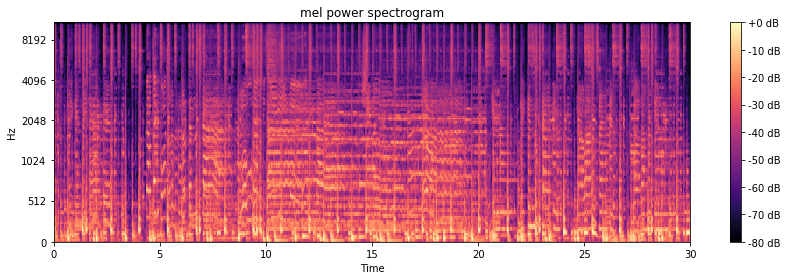

In [33]:
audio_path = SONG_FOLDER + 'testFile.wav'
y, sr = librosa.load(audio_path)
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128) 
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))

librosa.display.specshow(log_S, sr=sr, x_axis = 'time', y_axis='mel')
 
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

# Harmonic-percussive source separation

The aim of the Harmonic/Percussive separation is to decompose the original music signal to the harmonic (i.e. pitched instruments) and the percussive (non pitched instruments, percussion) parts of the signal. Such methods can be applied to audio mixing software, or can be adopted as preprocessing on other Music Information Retrieval Methods such as rhythm analysis or chord/tonality recognition.

In [34]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

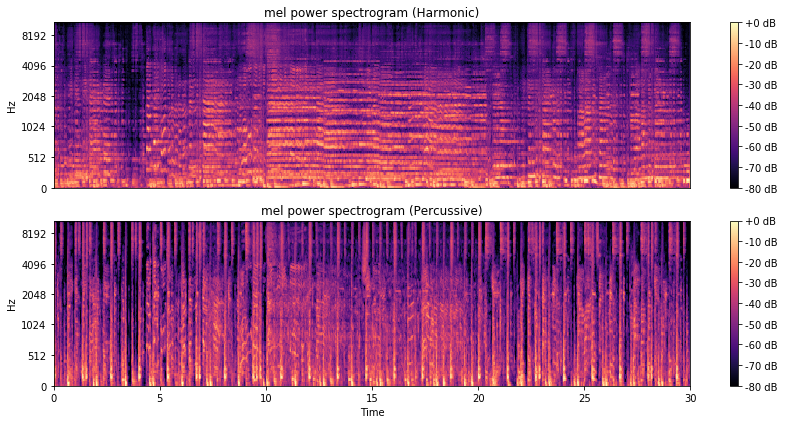

In [35]:

# Ddisplay a mel-scaled power (energy-squared) spectrogram
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)

# Convert to log scale (dB). Use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)

plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')
plt.title('mel power spectrogram (Harmonic)')
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram (Percussive)')
plt.colorbar(format='%+02.0f dB')

plt.tight_layout()

# Chromagram

Pitch class (or chroma) representations
are often used to encode harmony while suppressing variations
in octave height, loudness, or timbre.

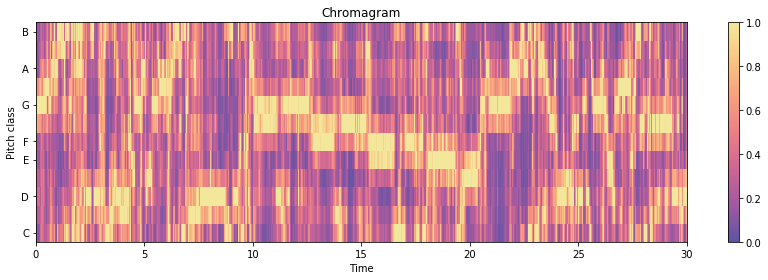

In [36]:
from palettable.cartocolors.sequential import Sunset_7_r

# Using a CQT-based chromagram here.  
# Use the harmonic component to avoid pollution from transients
D = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

plt.figure(figsize=(12,4))

librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1,  cmap = Sunset_7_r.mpl_colormap)
plt.title('Chromagram')
plt.colorbar()
plt.tight_layout()

# MFCC
Mel-frequency cepstral coefficients are commonly used to represent **texture** or **timbre** of sound.

In music, **texture** is how the melodic, rhythmic, and harmonic materials are combined in a composition, thus determining the overall quality of the sound in a piece. Texture is often described in regard to the density, or thickness, and range, or width, between lowest and highest pitches, in relative terms as well as more specifically distinguished according to the number of voices, or parts, and the relationship between these voices. For example, a thick texture contains many “layers” of instruments.


**Timbre** is the perceived sound quality of a musical note, sound or tone. 


#### Mel-Frequency cepstrum

In sound processing, the **mel-frequency cepstrum (MFC)** is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. 

**power spectrum:**

For a given signal, the power spectrum gives a plot of the portion of a signal's power (energy per unit time) falling within given frequency bins

/home/lildreamz/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


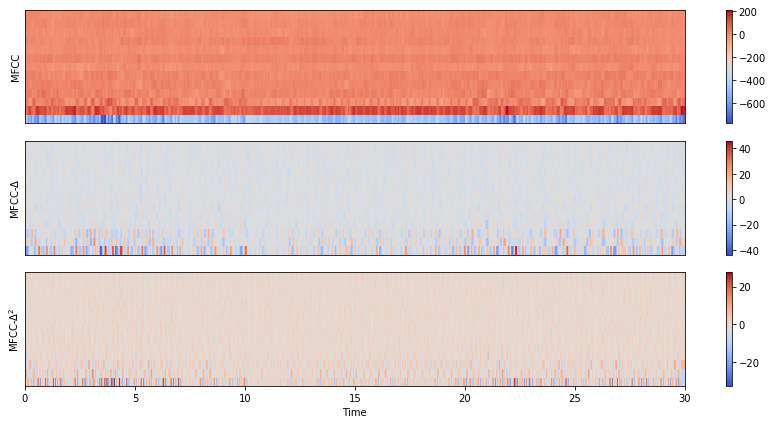

In [37]:


# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])



# Beat tracking

Beat tracker returns an estimate of the tempo (beats/min) and frame indices of beat events.



/home/lildreamz/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


<Figure size 864x432 with 0 Axes>

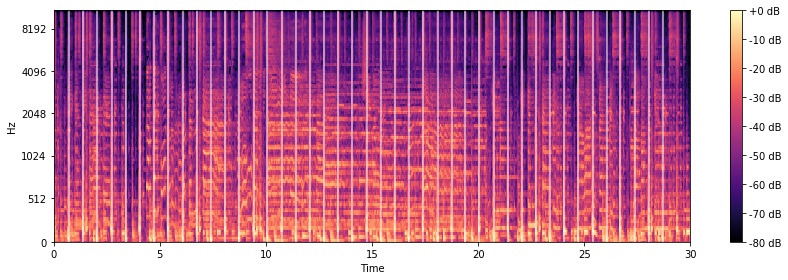

In [38]:
# Now, let's run the beat tracker.
# We'll use the percussive component for this part
plt.figure(figsize=(12, 6))
tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)
# Let's re-draw the spectrogram, but this time, overlay the detected beats
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Let's draw transparent lines over the beat frames
plt.vlines(librosa.frames_to_time(beats),
           1, 0.5 * sr,
           colors='w', linestyles='-', linewidth=2, alpha=0.5)

plt.axis('tight')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout()

In [39]:
url = "https://api.spotify.com/v1/me/playlists"
headers = {'Authorization': "Bearer {}".format(TOKEN)}
r = requests.get(url, headers=headers)
parsed = json.loads(r.text)

In [40]:
playlists = parsed['items']
for playlist in playlists:
    if playlist['collaborative'] == True:
        print(playlist)
        


{'collaborative': True, 'external_urls': {'spotify': 'https://open.spotify.com/playlist/4zPScbIBFDKIKtCM3PvuJV'}, 'href': 'https://api.spotify.com/v1/playlists/4zPScbIBFDKIKtCM3PvuJV', 'id': '4zPScbIBFDKIKtCM3PvuJV', 'images': [{'height': 640, 'url': 'https://mosaic.scdn.co/640/797e59fba47111923b437733b8bd0ceb03b795758b8c2d541300c4d13eb1cb5be80c26c1a94956fc92501ad97eba0f22b05aca03d90937dc4af2735ba0ce5df98bce411863c24fa4904523bc5030affe', 'width': 640}, {'height': 300, 'url': 'https://mosaic.scdn.co/300/797e59fba47111923b437733b8bd0ceb03b795758b8c2d541300c4d13eb1cb5be80c26c1a94956fc92501ad97eba0f22b05aca03d90937dc4af2735ba0ce5df98bce411863c24fa4904523bc5030affe', 'width': 300}, {'height': 60, 'url': 'https://mosaic.scdn.co/60/797e59fba47111923b437733b8bd0ceb03b795758b8c2d541300c4d13eb1cb5be80c26c1a94956fc92501ad97eba0f22b05aca03d90937dc4af2735ba0ce5df98bce411863c24fa4904523bc5030affe', 'width': 60}], 'name': 'earle and tiff ', 'owner': {'display_name': 'Tiffany Koval', 'external_urls': 

In [41]:
playlist_Id = '4zPScbIBFDKIKtCM3PvuJV'

In [42]:
url = "https://api.spotify.com/v1/playlists/4zPScbIBFDKIKtCM3PvuJV"
headers = {'Authorization': "Bearer {}".format(TOKEN)}
r = requests.get(url, headers=headers)
parsed = json.loads(r.text)

In [43]:
total_songs = parsed['tracks']['total']

In [44]:
parsed['tracks']['items'][0].keys()

dict_keys(['added_at', 'added_by', 'is_local', 'primary_color', 'track', 'video_thumbnail'])

In [45]:
parsed['tracks']['items'][0].keys()

dict_keys(['added_at', 'added_by', 'is_local', 'primary_color', 'track', 'video_thumbnail'])

In [46]:
mp3 links andparsed['tracks']['items'][0]['added_by']['id']

'tknoodle1'

In [47]:
parsed['tracks']['items'][0]['track'].keys()

dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'episode', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track', 'track_number', 'type', 'uri'])

In [48]:
parsed['tracks']['items'][0]['track']['preview_url']

'https://p.scdn.co/mp3-preview/9a55649cd7f1c63798f184c2f4ea6aba34daf4b9?cid=08c15eb1ecef4a339c36fea26459ea5d'

In [49]:
parsed['tracks']['items'][0]['track']['name']

'BULLETS'

In [50]:
songs = parsed['tracks']['items']
meta_data = []


for song in songs:
    added_by = song['added_by']['id']
    name = song['track']['name']
    name = name.replace(" ", "")
    web_file = song['track']['preview_url']
    if web_file == None:
        meta_data.append({"add_by": added_by, "name": name, "filename": "NoFile"})
        continue
    filename = added_by + "_" + name 
    meta_data.append({"add_by": added_by, "name": name, "filename": filename})
    print("Song name: %s. Was added by: %s.\nFILENAME: %s. link=%s\n"%(name, added_by, filename, web_file))
    # Download file
    data = urllib.request.urlretrieve(web_file,SONG_FOLDER + filename + ".mp3")
    mp3 = pydub.AudioSegment.from_mp3(SONG_FOLDER + filename + ".mp3")
    mp3.export(SONG_FOLDER + filename +".wav", format="wav")
    rate, audData  = scipy.io.wavfile.read(SONG_FOLDER+"file.wav")
    print("rate: %r\n"%(rate))


Song name: BULLETS. Was added by: tknoodle1.
FILENAME: tknoodle1_BULLETS. link=https://p.scdn.co/mp3-preview/9a55649cd7f1c63798f184c2f4ea6aba34daf4b9?cid=08c15eb1ecef4a339c36fea26459ea5d

rate: 44100

Song name: HidingInTheMelody. Was added by: tknoodle1.
FILENAME: tknoodle1_HidingInTheMelody. link=https://p.scdn.co/mp3-preview/cd1282e43fb5a938ccd6e5599b6d57a714ebff79?cid=08c15eb1ecef4a339c36fea26459ea5d

rate: 44100

Song name: InChains. Was added by: earleag.
FILENAME: earleag_InChains. link=https://p.scdn.co/mp3-preview/29bdfb733818801d2ce78b2a71fc0ef5f2de7139?cid=08c15eb1ecef4a339c36fea26459ea5d

rate: 44100

Song name: Unspoken. Was added by: tknoodle1.
FILENAME: tknoodle1_Unspoken. link=https://p.scdn.co/mp3-preview/270965080f6908ea293716e0c153f12f561f7b03?cid=08c15eb1ecef4a339c36fea26459ea5d

rate: 44100

Song name: FakeID. Was added by: tknoodle1.
FILENAME: tknoodle1_FakeID. link=https://p.scdn.co/mp3-preview/be77778e775ab289c54db9aad6015aa88577dec7?cid=08c15eb1ecef4a339c36fea2

rate: 44100

Song name: HearFromYou. Was added by: earleag.
FILENAME: earleag_HearFromYou. link=https://p.scdn.co/mp3-preview/3e402f5670c6402d6dcd2b9e5e460f0f854440fa?cid=08c15eb1ecef4a339c36fea26459ea5d

rate: 44100

Song name: WarmAnimal. Was added by: earleag.
FILENAME: earleag_WarmAnimal. link=https://p.scdn.co/mp3-preview/7b8bc9b60ca2029561936eb4e9e1ef51590d36aa?cid=08c15eb1ecef4a339c36fea26459ea5d

rate: 44100

Song name: TheTipOut. Was added by: tknoodle1.
FILENAME: tknoodle1_TheTipOut. link=https://p.scdn.co/mp3-preview/cbb0d4c1e7d3c8152dbfd21219c7472a648e3e64?cid=08c15eb1ecef4a339c36fea26459ea5d

rate: 44100



In [51]:
from palettable.colorbrewer.sequential import GnBu_9_r
from palettable.cartocolors.sequential import Sunset_7_r
DATA_FOLDER = '/home/lildreamz/Programming/jupyter_notebooks/spotifyAnalysis/'
chromas = []
e_chromas = []
t_chromas = []
meta_data = np.load(DATA_FOLDER+"playlist_meta_data.npy")
#plt.figure(figsize=(12,4))
#gs1 = gridspec.GridSpec(6, 7)
#gs1.update(wspace=0.0, hspace=0.0)
gs_ix = 0

for file in meta_data:    
    if file['filename'] == "NoFile":
        continue
    add_by = file['add_by']    
    filename = file['filename']+".wav"
    song_name = file['name']
    audio_path = SONG_FOLDER + filename
    y, sr = librosa.load(audio_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
    if add_by == 'tknoodle1':
        t_chromas.append({"chroma": C, "sr": sr })
    elif add_by == 'earleag':
        e_chromas.append({"chroma": C, "sr": sr})
    chromas.append({"add_by": add_by, "chroma": C, "sr": sr, "name": song_name})
    gs_ix = gs_ix + 1    
    

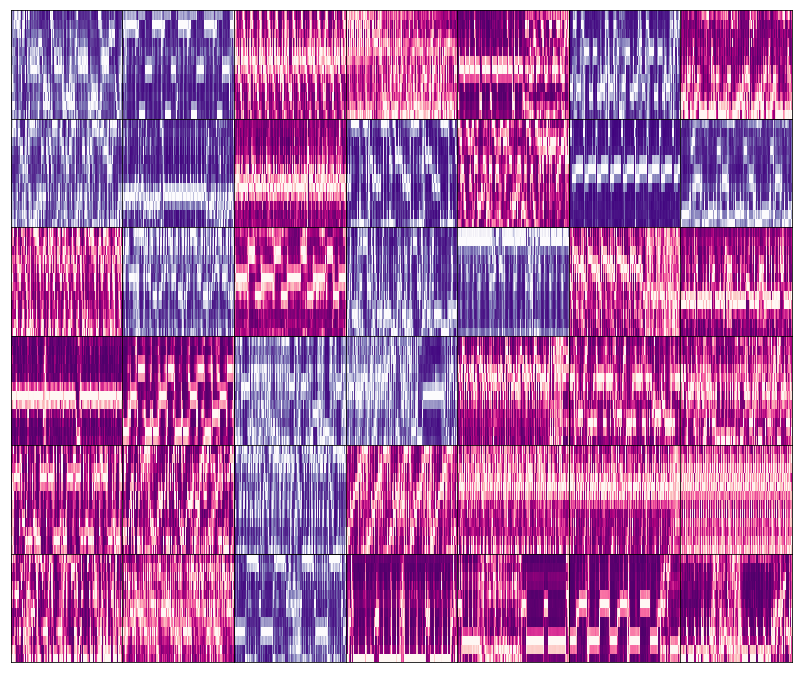

In [52]:

from palettable.colorbrewer.sequential import GnBu_9_r
from palettable.matplotlib import Viridis_3
from palettable.cartocolors.sequential import Sunset_7_r



plt.figure(figsize=(14,12))
gs1 = gridspec.GridSpec(6, 7)
gs1.update(wspace=0.0, hspace=0.0)
gs_ix = 0

all_indices = set(list(range(0,42)))
e_indices = set([0,1,5,7,8,10,12,13,15,17,18,23,24,30,37])
t_indices = all_indices - e_indices

_e_chroma = e_chromas.copy()
_t_chroma = t_chromas.copy()


shuffle(_e_chroma)
shuffle(_t_chroma)
for e in e_indices:
    plt.subplot(gs1[e])
    c = _e_chroma.pop()
    librosa.display.specshow(c['chroma'], sr=c['chroma'], 
                         vmin=0, vmax=1,  cmap =  plt.get_cmap('Purples_r'))
    
for t in t_indices:
    plt.subplot(gs1[t])
    c = _t_chroma.pop()
    librosa.display.specshow(c['chroma'], sr=c['sr'], 
                         vmin=0, vmax=1,  
                             cmap =plt.get_cmap('RdPu_r'))
    
plt.savefig("BuPu_tree.png")    


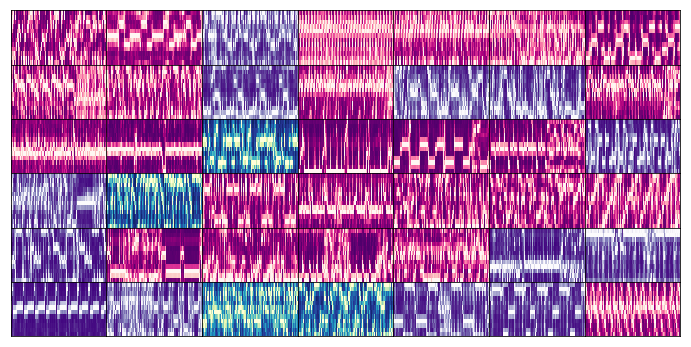

In [53]:
plt.figure(figsize=(12,6))
gs1 = gridspec.GridSpec(6, 7)
gs1.update(wspace=0.0, hspace=0.0)
gs_ix = 0

for chroma in chromas:
    plt.subplot(gs1[gs_ix])
    
    gs_ix = gs_ix + 1    
    if chroma['name'] == 'Dreganomics' or chroma['name'] == 'Casio' or chroma['name'] == 'Fades' or chroma['name'] == 'Look@Ugo':
        librosa.display.specshow(chroma['chroma'], sr=chroma['sr'], 
                                 vmin=0, vmax=1,  
                                 cmap = plt.get_cmap('YlGnBu_r'))
    elif chroma['add_by'] == 'tknoodle1':
        librosa.display.specshow(chroma['chroma'], 
                                sr=chroma['sr'], 
                               vmin=0, vmax=1,  
                              cmap = plt.get_cmap('RdPu_r'))
    elif chroma['add_by'] == 'earleag':        
        librosa.display.specshow(chroma['chroma'], 
                                 sr=chroma['sr'], 
                                 vmin=0, vmax=1,  
                                 cmap = plt.get_cmap('Purples_r'))

plt.savefig("songVizOrdered.png")    


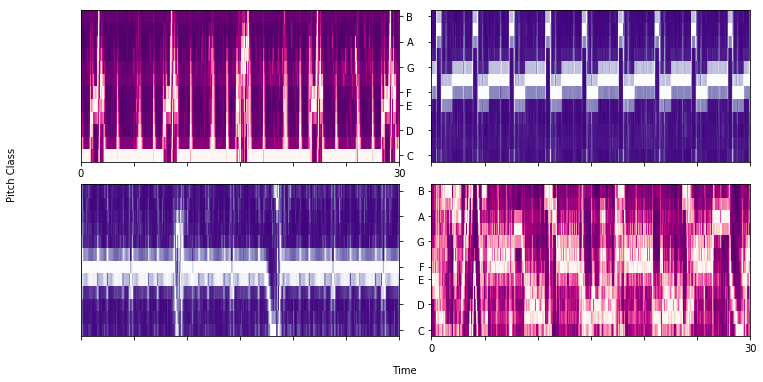

In [54]:

from palettable.cartocolors.sequential import Sunset_7_r
from palettable.colorbrewer.sequential import GnBu_9_r

_e_chroma = e_chromas.copy()
_t_chroma = t_chromas.copy()
shuffle(_e_chroma)
shuffle(_t_chroma)

fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(12, 6))
plt.subplots_adjust(hspace=0.15,wspace=0.1)
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Pitch Class', va='center', rotation='vertical')

ax1 = plt.subplot(2,2,1)
c = _t_chroma.pop()
librosa.display.specshow(c['chroma'], sr=c['sr'],
                         vmin=0, vmax=1, 
                         x_axis='time', y_axis='chroma',
                         cmap =  plt.get_cmap('RdPu_r'))
xticks = ax1.xaxis.get_major_ticks()
xticks[1].label1.set_visible(False)
xticks[2].label1.set_visible(False)
xticks[3].label1.set_visible(False)
xticks[4].label1.set_visible(False)
xticks[5].label1.set_visible(False)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.yaxis.tick_right()

ax2 = plt.subplot(2,2,2)    
c = _e_chroma.pop()
librosa.display.specshow(c['chroma'], sr=c['sr'], 
                         x_axis='time', y_axis='chroma',
                               vmin=0, vmax=1,
                        cmap = plt.get_cmap('Purples_r'))


ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xlabel("")
ax2.set_ylabel("")

ax3 = plt.subplot(2,2,3)
c = _t_chroma.pop()
librosa.display.specshow(c['chroma'], sr=c['sr'], 
                         x_axis='time', y_axis='chroma',
                               vmin=0, vmax=1,
                        cmap = plt.get_cmap('Purples_r'))

ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.yaxis.tick_right()



ax4 = plt.subplot(2,2,4)    
c = _e_chroma.pop()
librosa.display.specshow(c['chroma'], sr=c['sr'],
                         vmin=0, vmax=1, 
                         x_axis='time', y_axis='chroma',
                         cmap =  plt.get_cmap('RdPu_r'))


xticks = ax4.xaxis.get_major_ticks()
xticks[1].label1.set_visible(False)
xticks[2].label1.set_visible(False)
xticks[3].label1.set_visible(False)
xticks[4].label1.set_visible(False)
xticks[5].label1.set_visible(False)
ax4.set_xlabel("")
ax4.set_ylabel("")


plt.savefig("zoomedSongs.png")


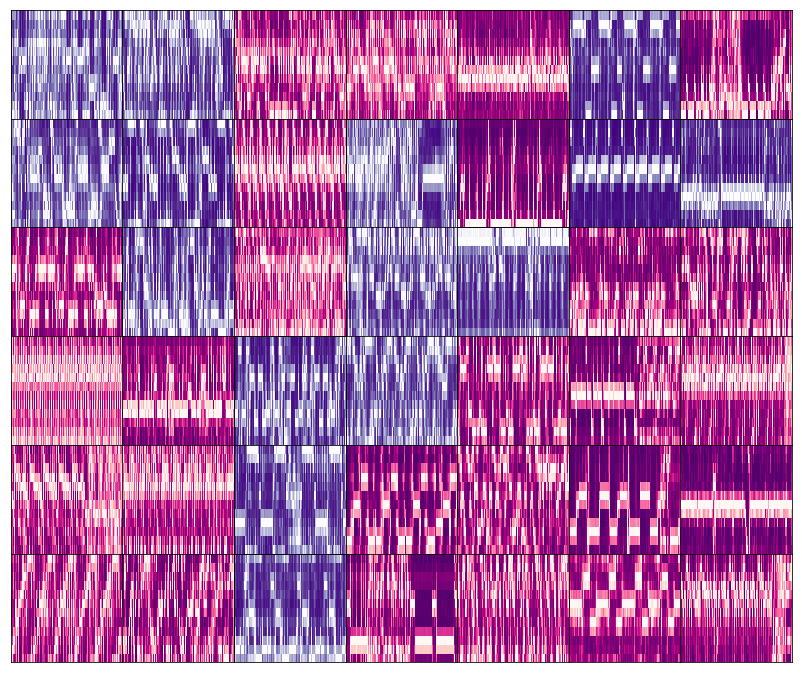

In [56]:
from palettable.cartocolors.sequential import Sunset_7_r
from palettable.colorbrewer.sequential import GnBu_9_r

plt.figure(figsize=(14,12))
gs1 = gridspec.GridSpec(6, 7)
gs1.update(wspace=0.0, hspace=0.0)
gs_ix = 0

all_indices = set(list(range(0,42)))
e_indices = set([0,1,5,7,8,10,12,13,15,17,18,23,24,30,37])
t_indices = all_indices - e_indices

_e_chroma = e_chromas.copy()
_t_chroma = t_chromas.copy()


shuffle(_e_chroma)
shuffle(_t_chroma)
for e in e_indices:
    plt.subplot(gs1[e])
    c = _e_chroma.pop()
    librosa.display.specshow(c['chroma'], sr=c['chroma'], 
                         vmin=0, vmax=1,  cmap =plt.get_cmap('Purples_r'))
    
for t in t_indices:
    plt.subplot(gs1[t])
    c = _t_chroma.pop()
    librosa.display.specshow(c['chroma'], sr=c['sr'], 
                         vmin=0, vmax=1,  
                             cmap =plt.get_cmap('RdPu_r'))

My own tracks


In [3]:
url = "https://api.spotify.com/v1/me/tracks"
headers = {'Authorization': "Bearer {}".format(TOKEN)}
r = requests.get(url, headers=headers)
parsed = json.loads(r.text)
count_songs = parsed["total"]
print("Total number of songs: {}".format(count_songs))

Total number of songs: 858


In [4]:
all_songs = []

for i in range(int(ceil(count_songs/50.0))):
    offset = 50*i
    url = "https://api.spotify.com/v1/me/tracks?limit=50&offset={}".format(offset)
    headers = {'Authorization': "Bearer {}".format(TOKEN)}
    r = requests.get(url, headers=headers)
    parsed = json.loads(r.text)
    
    all_songs.extend(parsed["items"])
    
print("Number of gathered songs: {}".format(len(all_songs)))   

Number of gathered songs: 858


In [5]:
song_ids = []

for song in all_songs:
    _id = song['track']['id']
    song_ids.append(_id)
print("Number of ids gathered: {}".format(len(all_songs)))    

Number of ids gathered: 858


In [6]:
all_songs[0]['track'].keys()

dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri'])

In [7]:
song_features_by_id = {}

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

s = requests.Session()
retries = Retry(total=300, backoff_factor=1, 
                status_forcelist=[502,503,504,429])
s.mount('https://', HTTPAdapter(max_retries=retries))

for song_id in song_ids:
    url = "https://api.spotify.com/v1/audio-features/{}".format(song_id)
    headers = {'Authorization': "Bearer {}".format(TOKEN)}
    r = s.get(url, headers=headers)
    
    parsed = json.loads(r.text)
    
    song_info = parsed

    
    try:
        a = song_info["type"]
    except:
        print(parsed)
        
    song_features_by_id[song_id] = song_info

In [8]:
print(len(song_features_by_id))

858


I want to get a better sense of the distribution of the following features in my playlist.

Do I listen to danceable songs?
Is the playlist a high energy or low energy playlist?


In [9]:
song_features_by_id['1Qf2f55yIV8bMxWmEpJoTb']

{'danceability': 0.656,
 'energy': 0.602,
 'key': 9,
 'loudness': -8.11,
 'mode': 0,
 'speechiness': 0.0301,
 'acousticness': 0.111,
 'instrumentalness': 7.28e-05,
 'liveness': 0.112,
 'valence': 0.721,
 'tempo': 105.874,
 'type': 'audio_features',
 'id': '1Qf2f55yIV8bMxWmEpJoTb',
 'uri': 'spotify:track:1Qf2f55yIV8bMxWmEpJoTb',
 'track_href': 'https://api.spotify.com/v1/tracks/1Qf2f55yIV8bMxWmEpJoTb',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1Qf2f55yIV8bMxWmEpJoTb',
 'duration_ms': 191213,
 'time_signature': 4}

/home/lildreamz/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'liveness of Songs')

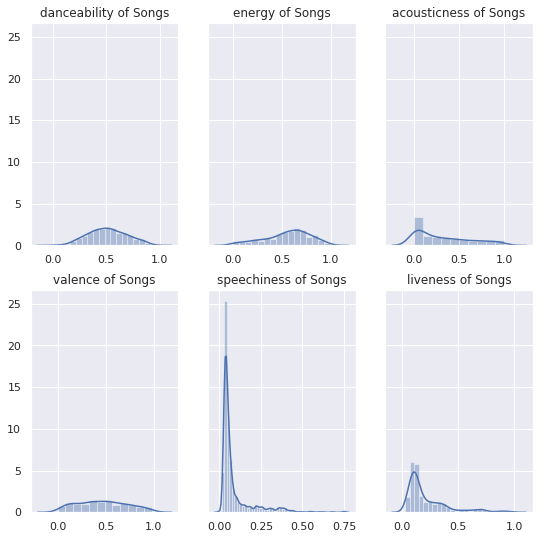

In [10]:
danceability =  []
energy = []
acousticness = []
valence = []
speechiness = []
liveness = []    

for song_id in song_features_by_id:
    d = song_features_by_id[song_id]['danceability']
    e = song_features_by_id[song_id]['energy']
    a = song_features_by_id[song_id]['acousticness']
    v = song_features_by_id[song_id]['valence']
    s = song_features_by_id[song_id]['speechiness']
    l = song_features_by_id[song_id]['liveness']
    speechiness.append(s)
    valence.append(v)
    acousticness.append(a)    
    energy.append(e)
    danceability.append(d)
    liveness.append(l)

sns.set(color_codes=True)
f, axes = plt.subplots(2, 3, figsize=(9,9), sharey=True)   


ax = sns.distplot(danceability, ax=axes[0,0])
ax.set_title("danceability of Songs")

ax = sns.distplot(energy, ax=axes[0,1])
ax.set_title("energy of Songs")

ax = sns.distplot(acousticness, ax=axes[0,2])
ax.set_title("acousticness of Songs")

ax = sns.distplot(valence, ax=axes[1,0])
ax.set_title("valence of Songs")

ax = sns.distplot(speechiness, ax=axes[1,1])
ax.set_title("speechiness of Songs")

ax = sns.distplot(liveness, ax=axes[1,2])
ax.set_title("liveness of Songs")

In [11]:
import pandas as pd

In [12]:
song_features_df = pd.DataFrame(
    { 'Danceability': danceability,
      'Energy': energy,
      'Acousticness': acousticness,
      'Valence': valence,
      'Speechiness': speechiness,
      'liveness': liveness
    })

The pairplot show that there might be a relationship between
Valence and Danceability
Acousticness and Energy

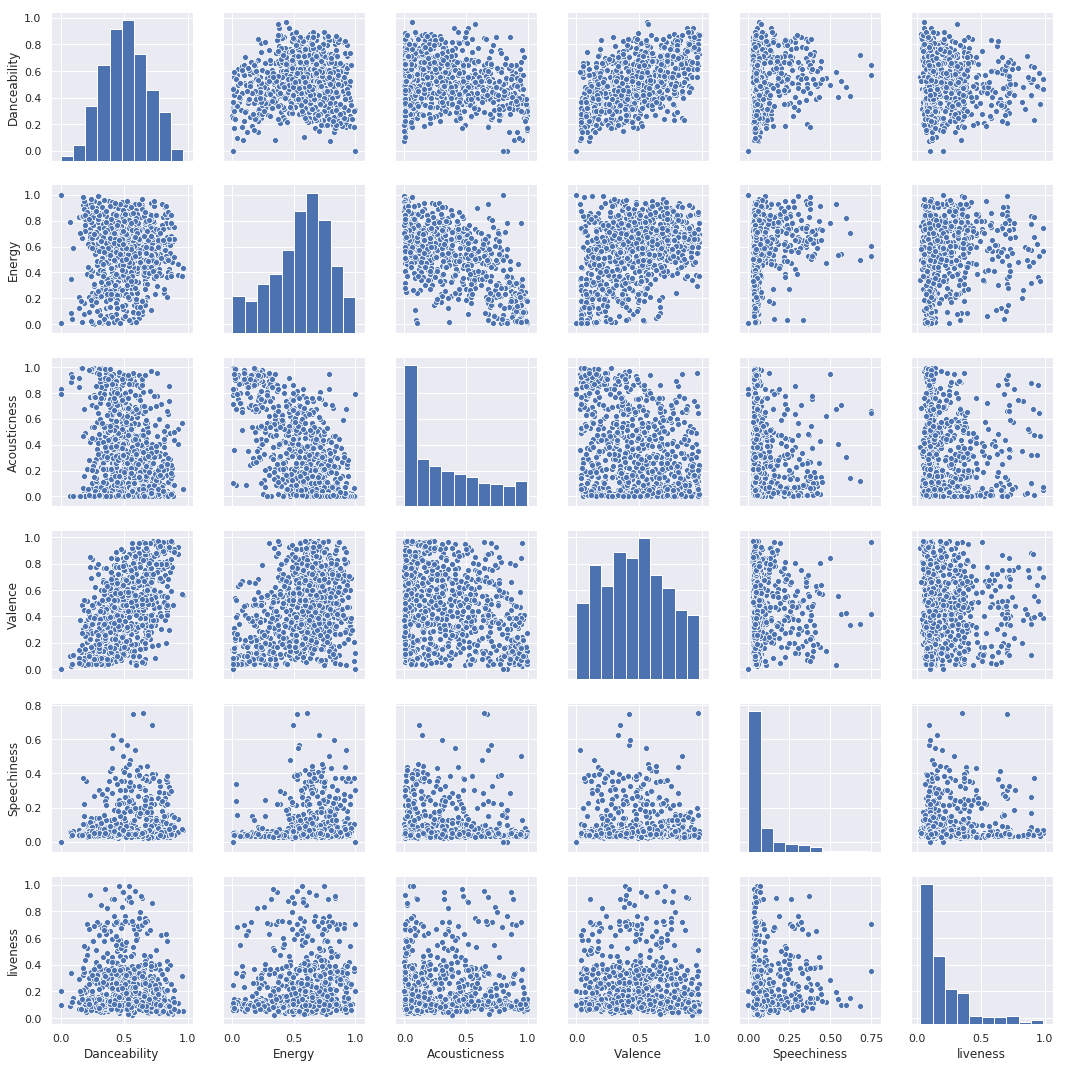

In [13]:
sns.pairplot(song_features_df)

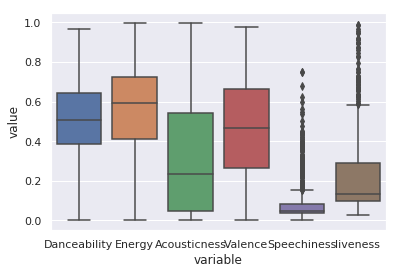

In [14]:
sns.boxplot(x="variable", y="value", data=pd.melt(song_features_df))

In [15]:
song_add_date = []

for song in all_songs:
    timestamp = song['added_at']
    song_add_date.append(timestamp)

In [16]:
from datetime import datetime

song_timestamp = [datetime.strptime(date, '%Y-%m-%dT%H:%M:%SZ').date() for date in song_add_date]

In [17]:
song_features_df = song_features_df.assign(Timestamp=song_timestamp)
song_features_df['Timestamp'] = pd.to_datetime(song_features_df['Timestamp']) 

In [18]:
song_features_df.head()

,Danceability,Energy,Acousticness,Valence,Speechiness,liveness,Timestamp
0,0.652,0.454,0.05050,0.639,0.1600,0.140,2019-03-04
1,0.817,0.753,0.15800,0.517,0.2500,0.103,2019-03-04
2,0.925,0.381,0.40300,0.876,0.0550,0.113,2019-03-04
3,0.782,0.545,0.00419,0.583,0.0408,0.200,2019-03-01
4,0.782,0.544,0.21200,0.753,0.0306,0.179,2019-03-01


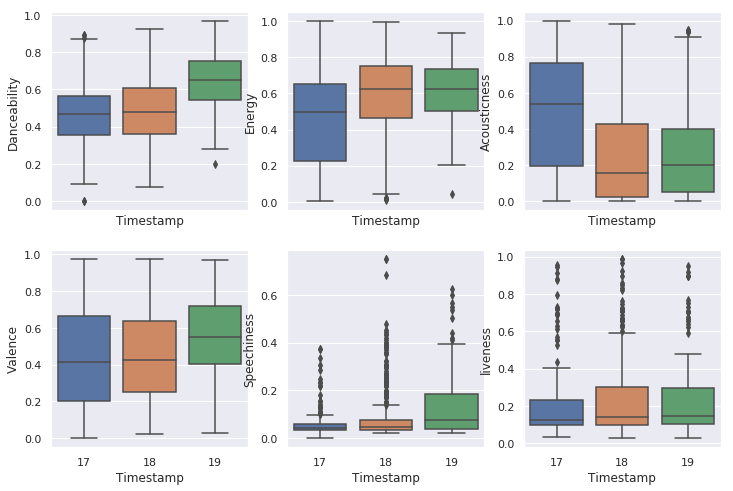

In [19]:
years = song_features_df.Timestamp.apply(lambda x: x.strftime('%y'))

sns.set(color_codes=True)
f, axes = plt.subplots(2, 3, figsize=(12,8), sharex=True)

ax = sns.boxplot(years, song_features_df.Danceability,ax=axes[0,0])

ax = sns.boxplot(years, song_features_df.Energy,ax=axes[0,1])

ax = sns.boxplot(years, song_features_df.Acousticness,ax=axes[0,2])

ax = sns.boxplot(years, song_features_df.Valence,ax=axes[1,0])

ax = sns.boxplot(years, song_features_df.Speechiness,ax=axes[1,1])

ax = sns.boxplot(years, song_features_df.liveness,ax=axes[1,2])


Experimental Im going to bin track to an album and see whats good if not I will just append the genres to a different dataframe.

In [20]:
artist_ids = set()

for song in all_songs:
    artists = song['track']['artists']
    for artist in artists:
        artist_ids.add(artist['id'])
    
print("Number of artists: {}".format(len(artist_ids)))    

Number of artists: 244


In [21]:
artist_info_by_id = {}

s = requests.Session()
retries = Retry(total=3000, backoff_factor=1, status_forcelist=[ 502, 503, 504, 429 ])
s.mount('https://', HTTPAdapter(max_retries=retries))

for artist_id in artist_ids:
    url = "https://api.spotify.com/v1/artists/{}".format(artist_id)
    headers = {'Authorization': "Bearer {}".format(TOKEN)}
    r = s.get(url, headers=headers)

    #TODO: check for error apart from dumb retries?

    parsed = json.loads(r.text)    

    artist_info = parsed

    #TODO: sanity checks?
    try:
        a = artist_info["genres"]
    except:
        print("Entry seems wrong. Fix it:")
        print(artist_info)
        break

    artist_info_by_id[artist_id] = artist_info

In [22]:
song_genres_based_on_artist = []
for song in all_songs:
    genres = []
    artists = song['track']['artists']
    for artist in artists:
        _id = artist['id']
        genres.extend(artist_info_by_id[_id]['genres'])
    
    song_genres_based_on_artist.append(genres)                 

In [23]:
song_timestamps = song_features_df.Timestamp

song_genres =  pd.DataFrame(
    {
        'artist_genres': song_genres_based_on_artist,
        'add_date': song_timestamps,
        'song_id': song_ids
})

In [24]:
song_genres.head()

,artist_genres,add_date,song_id
0,"[alternative r&b, chicago rap, conscious hip h...",2019-03-04,4K4l4lbc7LX6NjXxFp7E4c
1,"[alternative r&b, bedroom soul, bedroom soul, ...",2019-03-04,6Fd6BVP2VaoqK9LsuDCPJl
2,[soul flow],2019-03-04,0nKvSEAxTM0CeWllXv0Ay8
3,"[art pop, chillwave, dream pop, escape room, f...",2019-03-01,2jYOkLY0Q5jK8vVca6zaAE
4,"[funk, neo soul, soul]",2019-03-01,2jJulR1CTEuHsXpS6bGDou


In [25]:
def bagwords (df):
       
    listname = ['artist_genres']
  
    dicname = {name: [] for name in listname}
    dicname['song_id'] = []
    listid = []
    dicdf = {}
    vol = {}
    
    print(df.shape)
     
    for name in listname:       
        for idx in range(df[name].size):
            l = df[name][idx]
            r = names_to_words(l)
            dicname[name].append(r) 
        
        vectorizer = CountVectorizer(analyzer='word',max_features=30)
        feature = vectorizer.fit_transform(dicname[name]).toarray().tolist()
        vol[name] = vectorizer.get_feature_names()
        
        dicdf[name] = pd.DataFrame({name: feature}) 
        dicdf[name] = dicdf[name][name].apply(pd.Series)
        
        l = len(dicdf[name].columns)
        
        dicdf[name].columns = [(name + '_' +vol[name][x]) for x in range(l)]
        print('good')
     
    
    for idx in range(df['song_id'].size):
        sid = df['song_id'][idx]
        listid.append(sid)        
        dicdf['song_id'] = pd.DataFrame({'song_id':listid}) 

            
    result = pd.concat(dicdf.values(), axis =1)

    return result
    

def names_to_words(names):
    words = re.sub("[^a-zA-Z0-9]"," ",str(names)).lower().split()    
    words = [i for i in words if i not in set(stopwords.words("english"))]
    ## Need join as string for countvectorizer!
    return (" ".join(words))

def reduce_genres(gen):
    genre = re.sub("[^a-zA-Z0-9]"," ",str(gen)).lower().split()
    genre = [i for i in genre if i not in set(stopwords.words("english"))]
    mode1 = str(stats.mode(genre)).split('[')[1].split(']')[0]
    return mode1
    



In [26]:
song_genres = song_genres.dropna()

In [27]:
song_genres = song_genres[(song_genres.astype(str)['artist_genres'] != '[]')].reset_index()
song_genres.head()

,index,artist_genres,add_date,song_id
0,0,"[alternative r&b, chicago rap, conscious hip h...",2019-03-04,4K4l4lbc7LX6NjXxFp7E4c
1,1,"[alternative r&b, bedroom soul, bedroom soul, ...",2019-03-04,6Fd6BVP2VaoqK9LsuDCPJl
2,2,[soul flow],2019-03-04,0nKvSEAxTM0CeWllXv0Ay8
3,3,"[art pop, chillwave, dream pop, escape room, f...",2019-03-01,2jYOkLY0Q5jK8vVca6zaAE
4,4,"[funk, neo soul, soul]",2019-03-01,2jJulR1CTEuHsXpS6bGDou


In [28]:
song_genres['artist_genres'].apply(lambda x: x)


0      [alternative r&b, chicago rap, conscious hip h...
1      [alternative r&b, bedroom soul, bedroom soul, ...
2                                            [soul flow]
3      [art pop, chillwave, dream pop, escape room, f...
4                                 [funk, neo soul, soul]
5                   [aussietronica, french indietronica]
6            [bedroom pop, indie garage rock, indie r&b]
7      [indie garage rock, indie psych-rock, indietro...
8                                      [alternative r&b]
9      [gangster rap, hip hop, pop, pop rap, rap, sou...
10                                               [hyphy]
11     [cali rap, gangster rap, hip hop, hyphy, pop r...
12     [atl hip hop, hip hop, pop rap, rap, southern ...
13                                                [gqom]
14     [hip hop, pop rap, rap, southern hip hop, trap...
15     [hip hop, indie r&b, irish hip hop, rap, uk al...
16     [hip hop, pop rap, rap, trap music, undergroun...
17                    [chicago 

In [29]:
song_genres['reduced_genres'] = song_genres['artist_genres'].apply(lambda x: reduce_genres(x))


/home/lildreamz/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [30]:
song_genres['year'] = [x.year for x in song_genres['add_date']]
song_genres.head()

,index,artist_genres,add_date,song_id,reduced_genres,year
0,0,"[alternative r&b, chicago rap, conscious hip h...",2019-03-04,4K4l4lbc7LX6NjXxFp7E4c,'hip',2019
1,1,"[alternative r&b, bedroom soul, bedroom soul, ...",2019-03-04,6Fd6BVP2VaoqK9LsuDCPJl,'b',2019
2,2,[soul flow],2019-03-04,0nKvSEAxTM0CeWllXv0Ay8,'flow',2019
3,3,"[art pop, chillwave, dream pop, escape room, f...",2019-03-01,2jYOkLY0Q5jK8vVca6zaAE,'pop',2019
4,4,"[funk, neo soul, soul]",2019-03-01,2jJulR1CTEuHsXpS6bGDou,'soul',2019


In [69]:
song_genres_T = bagwords( song_genres )

(816, 6)
good


In [71]:
song_genres_T.head()

,artist_genres_album,artist_genres_alternative,artist_genres_art,artist_genres_bebop,artist_genres_blues,artist_genres_bop,artist_genres_classic,artist_genres_contemporary,artist_genres_cool,artist_genres_funk,...,artist_genres_post,artist_genres_progressive,artist_genres_psychedelic,artist_genres_rap,artist_genres_rock,artist_genres_soul,artist_genres_southern,artist_genres_symphonic,artist_genres_vocal,song_id
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,4K4l4lbc7LX6NjXxFp7E4c
1,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,6Fd6BVP2VaoqK9LsuDCPJl
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0nKvSEAxTM0CeWllXv0Ay8
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2jYOkLY0Q5jK8vVca6zaAE
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,2,0,0,0,2jJulR1CTEuHsXpS6bGDou


In [73]:
song_genres = song_genres.merge(song_genres_T, on='song_id', how='outer')
song_genres.head()

,index,artist_genres,add_date,song_id,reduced_genres,year,artist_genres_album,artist_genres_alternative,artist_genres_art,artist_genres_bebop,...,artist_genres_pop,artist_genres_post,artist_genres_progressive,artist_genres_psychedelic,artist_genres_rap,artist_genres_rock,artist_genres_soul,artist_genres_southern,artist_genres_symphonic,artist_genres_vocal
0,0,"[alternative r&b, chicago rap, conscious hip h...",2019-03-04,4K4l4lbc7LX6NjXxFp7E4c,'hip',2019,0,1,0,0,...,1,0,0,0,3,0,0,0,0,0
1,1,"[alternative r&b, bedroom soul, bedroom soul, ...",2019-03-04,6Fd6BVP2VaoqK9LsuDCPJl,'b',2019,0,2,0,0,...,0,0,0,0,0,0,2,0,0,0
2,2,[soul flow],2019-03-04,0nKvSEAxTM0CeWllXv0Ay8,'flow',2019,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,3,"[art pop, chillwave, dream pop, escape room, f...",2019-03-01,2jYOkLY0Q5jK8vVca6zaAE,'pop',2019,0,0,1,0,...,3,0,0,0,0,1,0,0,0,0
4,4,"[funk, neo soul, soul]",2019-03-01,2jJulR1CTEuHsXpS6bGDou,'soul',2019,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


In [79]:
song_genres = song_genres.drop(['artist_genres', 'add_date', 'index', 'song_id'], axis= 1)

In [81]:
song_genres.tail()

,reduced_genres,year,artist_genres_album,artist_genres_alternative,artist_genres_art,artist_genres_bebop,artist_genres_blues,artist_genres_bop,artist_genres_classic,artist_genres_contemporary,...,artist_genres_pop,artist_genres_post,artist_genres_progressive,artist_genres_psychedelic,artist_genres_rap,artist_genres_rock,artist_genres_soul,artist_genres_southern,artist_genres_symphonic,artist_genres_vocal
811,'rock',2017,1,0,0,0,2,0,1,0,...,0,0,0,1,0,10,0,1,0,0
812,'rock',2017,1,0,0,0,2,0,1,0,...,0,0,0,1,0,10,0,1,0,0
813,'rock',2017,1,0,0,0,2,0,1,0,...,0,0,0,1,0,10,0,1,0,0
814,'rock',2017,1,0,0,0,2,0,1,0,...,0,0,0,1,0,10,0,1,0,0
815,'rock',2017,1,0,0,0,2,0,1,0,...,0,0,0,1,0,10,0,1,0,0


In [77]:
song_genres.groupby('year')

In [83]:
file_name = 'song_genres.csv'
song_genres.to_csv(file_name, sep='\t')

In [90]:
genre_cols = song_genres.loc[:, "artist_genres_album":"artist_genres_vocal"]

In [93]:
Total = genre_cols.sum(axis=1)

In [94]:
df = song_genres.loc[:, "reduced_genres":"year"]

In [97]:
df = pd.concat([df, Total.rename('Val')], axis=1)


In [101]:
df['type'] = df['reduced_genres']

In [50]:
df.head()

,source,target,value,type
0,'afrobeat',2019,1,'afrobeat'
1,'alternative',2018,10,'alternative'
2,'alternative',2019,6,'alternative'
3,'ambient',2017,12,'ambient'
4,'americana',2017,5,'americana'


In [103]:
df.columns = ['source', 'target', 'value', 'type']

In [106]:
df.to_dict('records')

[{'source': "'hip'", 'target': 2019, 'value': 11, 'type': "'hip'"},
 {'source': "'b'", 'target': 2019, 'value': 6, 'type': "'b'"},
 {'source': "'flow'", 'target': 2019, 'value': 1, 'type': "'flow'"},
 {'source': "'pop'", 'target': 2019, 'value': 7, 'type': "'pop'"},
 {'source': "'soul'", 'target': 2019, 'value': 3, 'type': "'soul'"},
 {'source': "'aussietronica'",
  'target': 2019,
  'value': 0,
  'type': "'aussietronica'"},
 {'source': "'indie'", 'target': 2019, 'value': 5, 'type': "'indie'"},
 {'source': "'indie'", 'target': 2019, 'value': 7, 'type': "'indie'"},
 {'source': "'alternative'",
  'target': 2019,
  'value': 1,
  'type': "'alternative'"},
 {'source': "'hip'", 'target': 2019, 'value': 23, 'type': "'hip'"},
 {'source': "'hyphy'", 'target': 2019, 'value': 0, 'type': "'hyphy'"},
 {'source': "'rap'", 'target': 2019, 'value': 12, 'type': "'rap'"},
 {'source': "'hip'", 'target': 2019, 'value': 12, 'type': "'hip'"},
 {'source': "'gqom'", 'target': 2019, 'value': 0, 'type': "'gqom'

In [51]:
from ipysankeywidget import SankeyWidget
SankeyWidget(links=df.to_dict('records'))

SankeyWidget(links=[{'source': "'afrobeat'", 'target': 2019, 'value': 1, 'type': "'afrobeat'"}, {'source': "'a…

In [52]:
sankey = SankeyWidget(links=df.to_dict('records'))

In [56]:
sankey.auto_save_svg('test.svg')

SankeyWidget(links=[{'source': "'afrobeat'", 'target': 2019, 'value': 1, 'type': "'afrobeat'"}, {'source': "'a…

In [133]:
df.groupby(['source'])

,source,target,value,type
0,'hip',2019,11,'hip'
1,'b',2019,6,'b'
2,'flow',2019,1,'flow'
3,'pop',2019,7,'pop'
4,'soul',2019,3,'soul'


In [135]:
song_genres.head()

,reduced_genres,year,artist_genres_album,artist_genres_alternative,artist_genres_art,artist_genres_bebop,artist_genres_blues,artist_genres_bop,artist_genres_classic,artist_genres_contemporary,...,artist_genres_pop,artist_genres_post,artist_genres_progressive,artist_genres_psychedelic,artist_genres_rap,artist_genres_rock,artist_genres_soul,artist_genres_southern,artist_genres_symphonic,artist_genres_vocal
0,'hip',2019,0,1,0,0,0,0,0,0,...,1,0,0,0,3,0,0,0,0,0
1,'b',2019,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
2,'flow',2019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,'pop',2019,0,0,1,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,'soul',2019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


In [137]:
df = song_genres.loc[:,"reduced_genres":"year"]

In [34]:
df = song_genres.drop(['index', 'artist_genres', 'add_date', 'song_id'], axis=1)

In [35]:
df.head()

,reduced_genres,year
0,'hip',2019
1,'b',2019
2,'flow',2019
3,'pop',2019
4,'soul',2019


In [36]:
df = df.groupby(['reduced_genres', 'year']).size().reset_index(name='counts')

In [37]:
df.head()

,reduced_genres,year,counts
0,'afrobeat',2019,1
1,'alternative',2018,10
2,'alternative',2019,6
3,'ambient',2017,12
4,'americana',2017,5


In [38]:
df.columns = ['source', 'target', 'value']                                                                                                                                                  
df['type'] = df['source']  

In [39]:
df.head()

,source,target,value,type
0,'afrobeat',2019,1,'afrobeat'
1,'alternative',2018,10,'alternative'
2,'alternative',2019,6,'alternative'
3,'ambient',2017,12,'ambient'
4,'americana',2017,5,'americana'


In [48]:
from ipysankeywidget import SankeyWidget                                                                                                                                                    

In [49]:
sankey = sankeSankeyWidget(links=df.to_dict('records'))


NameError: name 'sankeSankeyWidget' is not defined

In [ ]:
.save_svg('test.svg')

In [42]:
import pylab 


In [45]:
df.sort_values('value')

,source,target,value,type
0,'afrobeat',2019,1,'afrobeat'
21,'disco',2017,1,'disco'
23,'downtempo',2019,1,'downtempo'
24,'experimental',2019,1,'experimental'
25,'flow',2019,1,'flow'
29,'garage',2018,1,'garage'
31,'gqom',2019,1,'gqom'
32,'hip',2017,1,'hip'
36,'hyphy',2019,1,'hyphy'
44,'metal',2019,1,'metal'
